# Timeseries generation demo

In this notebook we'll be exploring the timeseries generation functionality provided by the new endpoints that @Alex Kirk has deployed to the delta-backend API

In [1]:
import requests as re
import matplotlib.pyplot as plt
import json
import datetime as dt
from ipyleaflet import Map, GeoJSON
import time
import concurrent.futures
from datetime import datetime

STAC_ENDPOINT_URL = "https://staging-stac.delta-backend.xyz"
RASTER_ENDPOINT_URL = "https://staging-raster.delta-backend.xyz"

## Data discovery using the STAC endpoint

In [2]:
re.get(f"{STAC_ENDPOINT_URL}/collections").json()["collections"][8]["id"]

'no2-monthly'

In [3]:
re.get(f"{STAC_ENDPOINT_URL}/collections/no2-monthly").json()

{'id': 'no2-monthly',
 'type': 'Collection',
 'links': [{'rel': 'items',
   'type': 'application/geo+json',
   'href': 'https://staging-stac.delta-backend.xyz/collections/no2-monthly/items'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.xyz/'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.xyz/'},
  {'rel': 'self',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.xyz/collections/no2-monthly'}],
 'title': 'NO₂ Monthly',
 'extent': {'spatial': {'bbox': [[-180, -90, 180, 90]]},
  'temporal': {'interval': [['2016-01-01T00:00:00Z',
     '2022-01-01T00:00:00Z']]}},
 'license': 'MIT',
 'summaries': {'datetime': ['2016-01-01T00:00:00Z', '2022-02-01T00:00:00Z'],
  'cog_default': {'max': 50064805976866816, 'min': -6618294421291008}},
 'description': 'Darker colors indicate higher nitrogen dioxide (NO₂) levels and more activity. Lighter colors indicate lower levels o

In [4]:
{k:v for k,v in re.get(f"{STAC_ENDPOINT_URL}/collections/no2-monthly").json().items() if k in ["dashboard:is_periodic", "dashboard:time_density", "summaries"]}

{'summaries': {'datetime': ['2016-01-01T00:00:00Z', '2022-02-01T00:00:00Z'],
  'cog_default': {'max': 50064805976866816, 'min': -6618294421291008}},
 'dashboard:is_periodic': True,
 'dashboard:time_density': 'month'}

In [5]:
items = re.get(f"{STAC_ENDPOINT_URL}/collections/no2-monthly/items?limit=100").json()["features"]

In [6]:
items[0]

{'id': 'OMI_trno2_0.10x0.10_202202_Col3_V4-no2-monthly',
 'bbox': [-180.0, -90.0, 180.0, 90.0],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.xyz/collections/no2-monthly'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.xyz/collections/no2-monthly'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.xyz/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://staging-stac.delta-backend.xyz/collections/no2-monthly/items/OMI_trno2_0.10x0.10_202202_Col3_V4-no2-monthly'}],
 'assets': {'cog_default': {'href': 's3://covid-eo-data/OMNO2d_HRM/OMI_trno2_0.10x0.10_202202_Col3_V4.nc.tif',
   'type': 'image/tiff; application=geotiff; profile=cloud-optimized',
   'roles': ['data', 'layer'],
   'raster:bands': [{'scale': 1.0,
     'nodata': 'inf',
     'offset': 0.0,
     'sampling': 'area',
     'dat

In [7]:
bounding_box_france = { 
    "type": "Feature",
    "properties": {},
    "geometry": {
        "type": "Polygon",
        "coordinates": [[
            [
              -5.4534286,
              41.2632185
            ],
            [
              9.8678344,
              41.2632185
            ],
            [
              9.8678344,
              51.268318
            ],
            [
              -5.4534286,
              51.268318
            ],
            [
              -5.4534286,
              41.2632185
            ]
        ]]
    }
}



In [8]:
m = Map(center=(47,4), zoom=3)
geo = GeoJSON(data=bounding_box_france, style={"color":"red", "fillOpacity":0})
m.add_layer(geo)
m

Map(center=[47, 4], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [9]:
def generate_stats(items, bounding_box):
    stats = [
        {
            **re.post(
                f"{RASTER_ENDPOINT_URL}/cog/statistics", 
                params={
                    "url":item["assets"]["cog_default"]["href"]
                },
                json=bounding_box
            ).json()["properties"], 
             "datetime":item["properties"]["datetime"]
        }
        for item in items
    ]
    return stats

In [10]:
start = time.time()
stats = generate_stats(items, bounding_box_france)
end = time.time()
print(f"Elapsed time for small bounding box (france) {round(end-start,2)} seconds. Items queried: {len(items)}")

Elapsed time for small bounding box (france) 28.13 seconds. Items queried: 74


In [11]:
stats[0]

{'statistics': {'1': {'min': -1084004715462656.0,
   'max': 1.0274760067907584e+16,
   'mean': 1771445372358347.5,
   'count': 15149.0,
   'sum': 2.6835625945856606e+19,
   'std': 1214133036547102.0,
   'median': 1508695175331840.0,
   'majority': 4887620706369536.0,
   'minority': -1084004715462656.0,
   'unique': 15138.0,
   'histogram': [[216.0,
     4901.0,
     6675.0,
     1896.0,
     937.0,
     323.0,
     146.0,
     36.0,
     14.0,
     5.0],
    [-1084004715462656.0,
     51871762874368.0,
     1187748241211392.0,
     2323624719548416.0,
     3459501197885440.0,
     4595377676222464.0,
     5731254154559488.0,
     6867130632896512.0,
     8003007111233536.0,
     9138883589570560.0,
     1.0274760067907584e+16]],
   'valid_percent': 99.01,
   'masked_pixels': 151.0,
   'valid_pixels': 15149.0,
   'percentile_2': 138399994011975.67,
   'percentile_98': 5268545328696521.0}},
 'datetime': '2022-02-01T00:00:00Z'}

In [12]:
dates = [dt.datetime.strptime(stat["datetime"], "%Y-%m-%dT%H:%M:%SZ") for stat in stats]
means = [stat["statistics"]["1"]["mean"] for stat in stats]
std_devs = [stat["statistics"]["1"]["std"] for stat in stats]
upper_bounds = [m+s for (m,s) in zip(means, std_devs)]
lower_bounds = [m-s for (m,s) in zip(means, std_devs)]

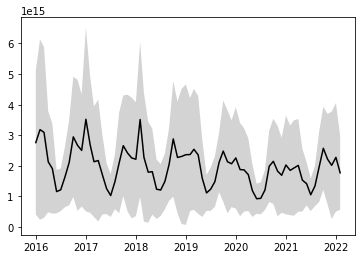

In [13]:
plt.plot(dates, means, 'black')
plt.fill_between(dates, upper_bounds, lower_bounds, facecolor="lightgrey", interpolate=True)

In [14]:
bounding_box_europe = {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -28.125,
              21.94304553343818
            ],
            [
              78.046875,
              21.94304553343818
            ],
            [
              78.046875,
              67.87554134672945
            ],
            [
              -28.125,
              67.87554134672945
            ],
            [
              -28.125,
              21.94304553343818
            ]
          ]
        ]
      }
    }

In [15]:
m = Map(center=(47,4), zoom=2)
geo = GeoJSON(data=bounding_box_europe, style={"color":"blue", "fillOpacity":0})
m.add_layer(geo)
geo = GeoJSON(data=bounding_box_france, style={"color":"red", "fillOpacity":0})
m.add_layer(geo)
m

Map(center=[47, 4], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [16]:
start = time.time()
stats_europe = generate_stats(items, bounding_box_europe)
end = time.time()
print(f"Elapsed time for large bounding box (europe) {round(end-start,2)} seconds. Items queried: {len(items)}")

Elapsed time for large bounding box (europe) 84.86 seconds. Items queried: 74


In [17]:
def get_stats_for_stac_item(item, bounding_box):
    return {
        **re.post(
            f"{RASTER_ENDPOINT_URL}/cog/statistics", 
            params={
                "url":item["assets"]["cog_default"]["href"]
            },
            json=bounding_box
        ).json()["properties"], 
         "datetime":item["properties"]["datetime"]
    }


def generate_stats_parallel(items, bounding_box):
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        results = list(
            executor.map(
                lambda item: get_stats_for_stac_item(item, bounding_box), 
                items
            )
        ) 
    return results


In [18]:
start = time.time()
stats_europe = generate_stats_parallel(items, bounding_box_europe)
end = time.time()
print(f"Elapsed time for large bounding box (europe) IN PARALLEL {round(end-start,2)} seconds. Items queried: {len(items)}")
stats_europe[0]

Elapsed time for large bounding box (europe) IN PARALLEL 10.33 seconds. Items queried: 74


{'statistics': {'1': {'min': -3660238775386112.0,
   'max': 1.839223322496205e+16,
   'mean': 879081748998886.2,
   'count': 443824.0,
   'sum': 3.901575781676817e+20,
   'std': 967804536142868.5,
   'median': 563360156352512.0,
   'majority': 200852585316352.0,
   'minority': -3660238775386112.0,
   'unique': 439006.0,
   'histogram': [[57.0,
     279092.0,
     144784.0,
     16787.0,
     2624.0,
     383.0,
     74.0,
     16.0,
     6.0,
     1.0],
    [-3660238775386112.0,
     -1454991575351296.0,
     750255624683520.0,
     2955502824718336.0,
     5160750024753152.0,
     7365997224787968.0,
     9571244424822784.0,
     1.17764916248576e+16,
     1.3981738824892416e+16,
     1.6186986024927232e+16,
     1.839223322496205e+16]],
   'valid_percent': 97.84,
   'masked_pixels': 9808.0,
   'valid_pixels': 443824.0,
   'percentile_98': 3907798709273883.0,
   'percentile_2': -57889157850071.04}},
 'datetime': '2022-02-01T00:00:00Z'}

In [19]:
OLD_API_URL = "https://8ib71h0627.execute-api.us-east-1.amazonaws.com/v1"
start = time.time()
stats = [
    re.post(
        f"{OLD_API_URL}/timelapse", 
        json={
            "geojson": bounding_box_europe, 
            "date":datetime.strptime(item["properties"]["datetime"], "%Y-%m-%dT%H:%M:%SZ").strftime("%Y%m"),
            "datasetId": "no2", 
        }
    ) 
    for item in items
]
end = time.time()
print(f"Elapsed time for large bounding box (europe) {round(end-start,2)} seconds. Items queried: {len(items)}")
print(stats[0].json())

start = time.time()
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    stats = list(
        executor.map(
            lambda item: re.post(
                f"{OLD_API_URL}/timelapse", 
                json={
                    "geojson": bounding_box_europe, 
                    "date":datetime.strptime(item["properties"]["datetime"], "%Y-%m-%dT%H:%M:%SZ").strftime("%Y%m"),
                    "datasetId": "no2", 
                }
            ) , 
            items
        )
    ) 
end = time.time()
print(f"Elapsed time for large bounding box (europe) IN PARALLEL {round(end-start,2)} seconds. Items queried: {len(items)}")
print(stats[0].json())

Elapsed time for large bounding box (europe) 89.54 seconds. Items queried: 74
{'mean': 878818261655406.0, 'median': 562746412236800.0}
Elapsed time for large bounding box (europe) IN PARALLEL 10.7 seconds. Items queried: 74
{'mean': 878818261655406.0, 'median': 562746412236800.0}
